# EXPLORATION_11

## 프로젝트 : 폐렴 진단기 성능개선

## 폐렴을 진단해보자(1)

### 1. Set-up
가장 먼저, 패키지(라이브러리)들을 import 해보겠습니다.

우리가 이번 프로젝트에서 사용할 패키지 목록입니다.

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

앞으로 필요한 변수들을 생성합니다.

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

print(ROOT_PATH)

/aiffel/aiffel


In [3]:
# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

### 2. 데이터 가져오기
import를 했으니 데이터를 가져와 보겠습니다. 데이터를 열어보면 이미 train, val(validation), test 로 나누어져 있습니다. 열어보셨으면 이제 각 데이터들의 개수를 한번 체크해보죠.

In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


train 안에는 5216개, test 안에는 624개, val 안에는 16개가 있습니다.

개수 비는 89%, 10.7%, 0.3% 입니다. val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와보겠습니다.

train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할하겠습니다.

In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


이제 train은 4185개, test는 624개, val은 1047개가 되었습니다. test_size를 수정하면 개수는 달라질 수 있습니다.

train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 한번 보겠습니다.

In [6]:
# 정상 이미지와 폐렴 이미지를 구분해야 하는데
# 다행히도 파일 경로에 힌트가 있어요
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0582-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person313_bacteria_1457.jpeg


In [7]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있습니다. 우리가 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 합니다. 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정입니다. test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없습니다.

tf.data 인스턴스를 만들어 봅시다. tf.data는 tensorflow에서 학습시킬 때, 배치처리 작업을 보다 효율적으로 할 수 있도록 해줍니다.

In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

Train 데이터셋, validation 데이터셋 개수 확인을 해보겠습니다.

In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


현재 이미지에는 라벨 데이터가 따로 없습니다.
파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보겠습니다.

In [10]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높습니다.
이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여봅시다.
decode_img 함수와 process_path 함수를 만들겠습니다.

process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경합니다. get_label을 이용해서 라벨 값을 가져옵니다.

In [11]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train 데이터 셋과 validation 데이터 셋을 만듭니다. num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리해 줍니다.



In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인해봅시다.

In [13]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


사이즈가 잘 변환되어 있고 라벨도 잘 들어가 있군요! 참고로, 코드에서 train_ds.take(1)은 하나의 데이터만 가져온다는 의미입니다.

위에서 train과 validation 데이터셋을 만든 것처럼 test 데이터셋도 만들어 보겠습니다. 그리고 데이터 개수도 확인해보겠습니다.

In [14]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줍니다.
밑에 있는 prepare_for_training() 함수는 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환 시켜줍니다.

shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.

repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다.
예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.

batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.
예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.

prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

In [15]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds_basic = prepare_for_training(train_ds)
val_ds_basic = prepare_for_training(val_ds)

### augmentation
augmentation 기법을 고려해 볼 수 있을 것입니다. 그러나 의료 영상인 경우, 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다.
그래서 augmentation 도입은 신중해야 합니다.

만약 예를 들어 좌우 반전 정도의 augmentation만 도입한다고 한다면 다음과 같이 진행될 것입니다.



In [16]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training_aug(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_aug = prepare_for_training_aug(train_ds)
val_ds_aug = prepare_for_training_aug(val_ds)

### 3. 데이터 시각화
데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출합니다. 추출된 배치를 image와 label 데이터 셋으로 나눕니다. 이제 show_batch() 함수를 이용해서 결과 사진을 보겠습니다.



### 기존

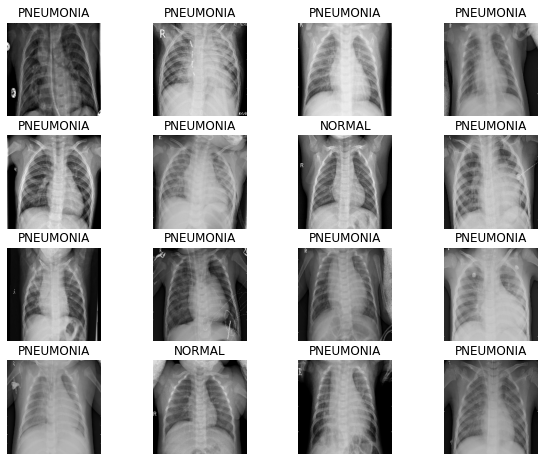

In [17]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds_basic))
show_batch(image_batch.numpy(), label_batch.numpy())

### augmentation

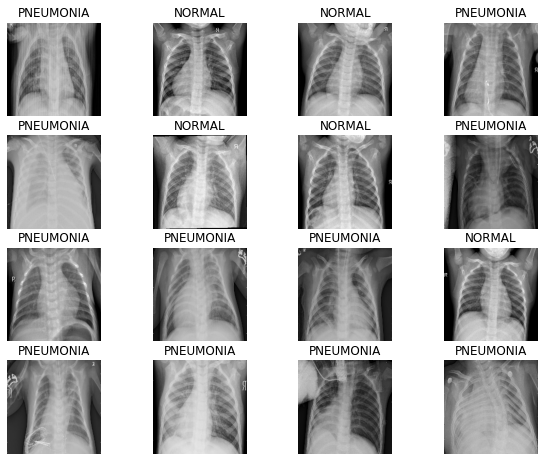

In [18]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch_aug, label_batch_aug = next(iter(train_ds_aug))
show_batch(image_batch_aug.numpy(), label_batch_aug.numpy())

## 폐렴을 진단해보자(2)
### 4. CNN 모델링
가장 대표적인 딥러닝 모델인 CNN을 모델링하고 결과를 만들어 보겠습니다.

여러분들도 많이 봐 왔던 모델이기 때문에 잘 아시겠지만 기억이 안 나시는 분들에게 참고할 만한 사이트를 소개해드리겠습니다.

먼저, Convolution block을 만듭니다. conv_block()의 구성은 Convolution을 두 번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결합니다. 그리고 Max Pooling을 합니다.

In [19]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        #tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

**Dense Block** 은 아래와 같이 만듭니다.

#### 1. BatchNormalization & Dropout 둘다 있음

In [20]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

#### 2. BatchNormalization만

In [21]:
def dense_block_B(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
    
    ])
    
    return block

#### 3. Dropout만

In [22]:
def dense_block_D(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

#### 4. BatchNormalization & Dropout 둘다 없음

In [23]:
def dense_block_no(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        
    ])
    
    return block

우리가 만들 CNN 모델은 약간의 수정을 거쳐 만들어진 모델입니다. 전형적인 CNN 모델과는 약간 다른 모델입니다.

어떤 부분이 가장 특이한가요? 눈에 띄셨을지 모르겠지만, 방금 만들어진 모델에는 Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용되고 있습니다.
일반적으로 이런 방법은 잘 사용되지 않거나, 금기시되기도 합니다. 대표적으로 아래와 같은 논문의 사례를 들 수 있습니다.

위 논문에서는 variance shift를 억제하는 Batch Normalization과 이를 유발하는 Dropout을 동시에 사용하는 것이 어울리지 않는다고 밝히고 있습니다.

그러나, 실용적으로는 두 방법을 같이 쓰는 것이 낫다고 보는 견해도 없는 것은 아닙니다. 예외적으로 동시에 사용하는 것이 성능 향상에 도움을 주는 경우가 실제로 있습니다. 아래 논문과 같이 두 방법을 같이 쓰는 것을 옹호하는 경우도 있습니다.

이번 실습에서는 두 가지를 함께 사용하는 이 모델이 성능 향상에 도움이 될지 여부도 흥미롭게 살펴볼만 한 부분입니다.

In [24]:
# 1. BatchNormalization & Dropout 둘다 있음
def build_model_1():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [25]:
# 2. BatchNormalization만
def build_model_2():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_B(512),
        dense_block_B(128),
        dense_block_B(64),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [26]:
# 3. Dropout만
def build_model_3():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_D(512, 0.7),
        dense_block_D(128, 0.5),
        dense_block_D(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [27]:
# 4. BatchNormalization & Dropout 둘다 없음
def build_model_4():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_no(512),
        dense_block_no(128),
        dense_block_no(64),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 5. 데이터 imbalance 처리
위에서 얘기했던 데이터 imbalance 문제입니다.
'Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 많이 있었죠? 한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있습니다.

이런 문제들을 해결하는 방법으로 Weight balancing이라는 테크닉이 사용됩니다. Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다. Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있습니다. 상세한 내용은 아래 링크를 참고합시다.

아래 코드에서 weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅합니다. 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됩니다.



In [28]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


### 6. 모델 훈련
이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택합니다. 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언합니다.

이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다. optimizer로 'adam'을 사용합니다.
성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용합니다.

#### 1. 기존모델

In [29]:
with tf.device('/GPU:0'):
    model = build_model_1()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

모델을 fit 해보겠습니다. 각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어줍니다. (모델 학습시 약 20분 이상 소요 됩니다.)

In [30]:
# '조기 종료'를 뜻하는 EarlyStopping은 특정 조건이 충족되면 훈련을 멈추는 역할을 함
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

In [31]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_basic,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs= EPOCHS,   #EPOCHS
        validation_data=val_ds_basic,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,callbacks=[es]
    )

Epoch 1/10
261/261 [==============================] - 52s 133ms/step - loss: 0.4807 - accuracy: 0.7693 - precision: 0.9339 - recall: 0.7385 - val_loss: 2.6736 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 34s 131ms/step - loss: 0.1916 - accuracy: 0.9301 - precision: 0.9808 - recall: 0.9243 - val_loss: 5.2885 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 34s 130ms/step - loss: 0.1684 - accuracy: 0.9411 - precision: 0.9834 - recall: 0.9373 - val_loss: 0.6507 - val_accuracy: 0.7558 - val_precision: 0.7502 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 34s 131ms/step - loss: 0.2212 - accuracy: 0.9253 - precision: 0.9748 - recall: 0.9233 - val_loss: 0.0978 - val_accuracy: 0.9635 - val_precision: 0.9594 - val_recall: 0.9921
Epoch 5/10
261/261 [==============================] - 33s 126ms/step - loss: 0.1780 - accura

#### 2. 기존 모델 + augmentation

In [32]:
with tf.device('/GPU:0'):
    model_aug = build_model_1()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_aug.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [33]:
with tf.device('/GPU:0'):
    history_aug = model_aug.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs= EPOCHS,   #EPOCHS, 시간상 줄임 원래는 위에 25
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,callbacks=[es]
    )

Epoch 1/10
261/261 [==============================] - 39s 122ms/step - loss: 0.4319 - accuracy: 0.7949 - precision: 0.9451 - recall: 0.7631 - val_loss: 2.0711 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 32s 125ms/step - loss: 0.2561 - accuracy: 0.8973 - precision: 0.9670 - recall: 0.8925 - val_loss: 1.6892 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 34s 131ms/step - loss: 0.2186 - accuracy: 0.9197 - precision: 0.9663 - recall: 0.9223 - val_loss: 0.7945 - val_accuracy: 0.7356 - val_precision: 0.7351 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 34s 131ms/step - loss: 0.1838 - accuracy: 0.9386 - precision: 0.9801 - recall: 0.9371 - val_loss: 0.4726 - val_accuracy: 0.8000 - val_precision: 0.7860 - val_recall: 1.0000
Epoch 5/10
261/261 [==============================] - 35s 133ms/step - loss: 0.2098 - accura

#### 3. BatchNormalization만

In [34]:
with tf.device('/GPU:0'):
    model_B = build_model_2()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_B.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [35]:
with tf.device('/GPU:0'):
    history_B = model_B.fit(
        train_ds_basic,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs= EPOCHS,   #EPOCHS
        validation_data=val_ds_basic,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,callbacks=[es]
    )

Epoch 1/10
261/261 [==============================] - 39s 122ms/step - loss: 0.2810 - accuracy: 0.8756 - precision: 0.9718 - recall: 0.8588 - val_loss: 2.2537 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 32s 122ms/step - loss: 0.1499 - accuracy: 0.9416 - precision: 0.9835 - recall: 0.9381 - val_loss: 5.4997 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 32s 122ms/step - loss: 0.1124 - accuracy: 0.9593 - precision: 0.9876 - recall: 0.9575 - val_loss: 0.1168 - val_accuracy: 0.9500 - val_precision: 0.9917 - val_recall: 0.9397
Epoch 4/10
261/261 [==============================] - 33s 126ms/step - loss: 0.1139 - accuracy: 0.9574 - precision: 0.9885 - recall: 0.9538 - val_loss: 0.1073 - val_accuracy: 0.9538 - val_precision: 0.9496 - val_recall: 0.9895
Epoch 5/10
261/261 [==============================] - 33s 128ms/step - loss: 0.0922 - accura

#### 4. Dropout만

In [36]:
with tf.device('/GPU:0'):
    model_D = build_model_3()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_D.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [37]:
with tf.device('/GPU:0'):
    history_D = model_D.fit(
        train_ds_basic,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs= EPOCHS,   #EPOCHS
        validation_data=val_ds_basic,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,callbacks=[es]
    )

Epoch 1/10
261/261 [==============================] - 38s 122ms/step - loss: 1.6215 - accuracy: 0.7239 - precision: 0.8893 - recall: 0.7139 - val_loss: 1.9322 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 32s 121ms/step - loss: 0.3766 - accuracy: 0.8428 - precision: 0.9583 - recall: 0.8251 - val_loss: 4.0305 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 31s 120ms/step - loss: 0.2279 - accuracy: 0.9044 - precision: 0.9767 - recall: 0.8925 - val_loss: 0.8967 - val_accuracy: 0.7500 - val_precision: 0.7458 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 32s 124ms/step - loss: 0.1717 - accuracy: 0.9316 - precision: 0.9833 - recall: 0.9245 - val_loss: 0.1256 - val_accuracy: 0.9327 - val_precision: 0.9873 - val_recall: 0.9198
Epoch 5/10
261/261 [==============================] - 33s 126ms/step - loss: 0.1465 - accura

#### 5. BatchNormalization & Dropout 둘 다 없음

In [38]:
with tf.device('/GPU:0'):
    model_no = build_model_4()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_no.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [39]:
with tf.device('/GPU:0'):
    history_no = model_no.fit(
        train_ds_basic,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs= EPOCHS,   #EPOCHS
        validation_data=val_ds_basic,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,callbacks=[es]
    )

Epoch 1/10
261/261 [==============================] - 38s 123ms/step - loss: 0.3720 - accuracy: 0.8838 - precision: 0.9635 - recall: 0.8769 - val_loss: 1.8721 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 32s 124ms/step - loss: 0.1568 - accuracy: 0.9478 - precision: 0.9794 - recall: 0.9505 - val_loss: 9.1449 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 32s 124ms/step - loss: 0.0895 - accuracy: 0.9706 - precision: 0.9926 - recall: 0.9675 - val_loss: 0.1156 - val_accuracy: 0.9567 - val_precision: 0.9556 - val_recall: 0.9869
Epoch 4/10
261/261 [==============================] - 34s 129ms/step - loss: 0.0857 - accuracy: 0.9659 - precision: 0.9895 - recall: 0.9642 - val_loss: 0.2571 - val_accuracy: 0.8856 - val_precision: 1.0000 - val_recall: 0.8438
Epoch 5/10
261/261 [==============================] - 34s 131ms/step - loss: 0.0750 - accura

#### 6. BatchNormalization & Dropout 둘 다 없음 + augmentation

In [40]:
with tf.device('/GPU:0'):
    model_no_aug = build_model_4()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_no_aug.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [41]:
with tf.device('/GPU:0'):
    history_no_aug = model_no_aug.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs= EPOCHS,   #EPOCHS
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,callbacks=[es]
    )

Epoch 1/10
261/261 [==============================] - 39s 125ms/step - loss: 0.6524 - accuracy: 0.8293 - precision: 0.9359 - recall: 0.8252 - val_loss: 1.5642 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 34s 130ms/step - loss: 0.1716 - accuracy: 0.9378 - precision: 0.9832 - recall: 0.9334 - val_loss: 3.8105 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 34s 132ms/step - loss: 0.1267 - accuracy: 0.9528 - precision: 0.9862 - recall: 0.9504 - val_loss: 0.5353 - val_accuracy: 0.7606 - val_precision: 0.9981 - val_recall: 0.6754
Epoch 4/10
261/261 [==============================] - 35s 133ms/step - loss: 0.1203 - accuracy: 0.9549 - precision: 0.9879 - recall: 0.9509 - val_loss: 0.1105 - val_accuracy: 0.9577 - val_precision: 0.9878 - val_recall: 0.9542
Epoch 5/10
261/261 [==============================] - 35s 134ms/step - loss: 0.1010 - accura

#### 7. BatchNormalization만 + augmentation

In [42]:
with tf.device('/GPU:0'):
    model_B_aug = build_model_2()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_B_aug.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [43]:
with tf.device('/GPU:0'):
    history_B_aug = model_B_aug.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs= EPOCHS,   #EPOCHS
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,callbacks=[es]
    )

Epoch 1/10
261/261 [==============================] - 42s 131ms/step - loss: 0.3080 - accuracy: 0.8578 - precision: 0.9620 - recall: 0.8414 - val_loss: 0.8791 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 34s 131ms/step - loss: 0.1843 - accuracy: 0.9298 - precision: 0.9769 - recall: 0.9276 - val_loss: 3.9047 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 34s 130ms/step - loss: 0.1407 - accuracy: 0.9419 - precision: 0.9837 - recall: 0.9377 - val_loss: 0.1279 - val_accuracy: 0.9462 - val_precision: 0.9346 - val_recall: 0.9961
Epoch 4/10
261/261 [==============================] - 34s 131ms/step - loss: 0.1477 - accuracy: 0.9453 - precision: 0.9849 - recall: 0.9412 - val_loss: 0.2883 - val_accuracy: 0.8769 - val_precision: 1.0000 - val_recall: 0.8325
Epoch 5/10
261/261 [==============================] - 34s 131ms/step - loss: 0.1071 - accura

#### 8. Dropout만 + augmentation

In [44]:
with tf.device('/GPU:0'):
    model_D_aug = build_model_3()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_D_aug.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [45]:
with tf.device('/GPU:0'):
    history_D_aug = model_D_aug.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs= EPOCHS,   #EPOCHS
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,callbacks=[es]
    )

Epoch 1/10
261/261 [==============================] - 41s 131ms/step - loss: 2.1363 - accuracy: 0.6289 - precision: 0.8304 - recall: 0.6342 - val_loss: 3.0998 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 35s 134ms/step - loss: 0.4166 - accuracy: 0.8530 - precision: 0.9476 - recall: 0.8507 - val_loss: 3.5282 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 34s 131ms/step - loss: 0.3414 - accuracy: 0.8781 - precision: 0.9629 - recall: 0.8683 - val_loss: 0.1802 - val_accuracy: 0.9462 - val_precision: 0.9744 - val_recall: 0.9514
Epoch 4/10
261/261 [==============================] - 34s 131ms/step - loss: 0.2957 - accuracy: 0.8801 - precision: 0.9723 - recall: 0.8641 - val_loss: 0.1980 - val_accuracy: 0.9279 - val_precision: 0.9832 - val_recall: 0.9175
Epoch 5/10
261/261 [==============================] - 34s 131ms/step - loss: 0.1990 - accura

### 7. 결과 확인
이제 결과를 확인해보겠습니다. 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여줍니다.

#### 1. 기존 모델 

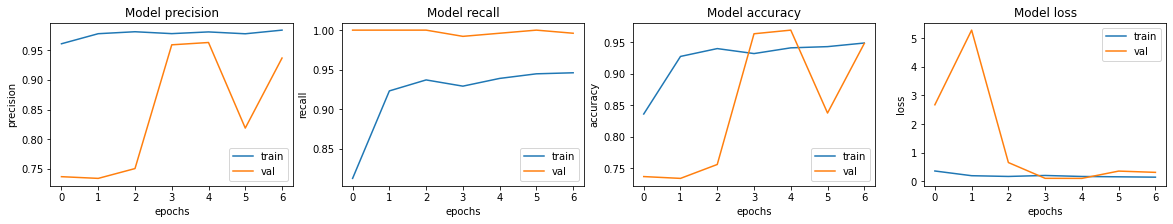

In [46]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#### 2. 기존 모델 + augmentation

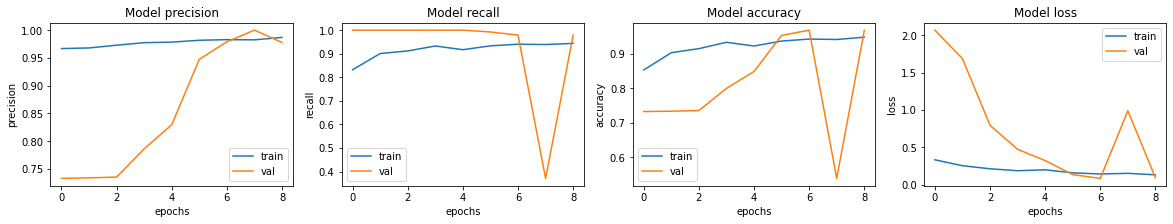

In [47]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_aug.history[met])
    ax[i].plot(history_aug.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#### 3.  BatchNormalization만

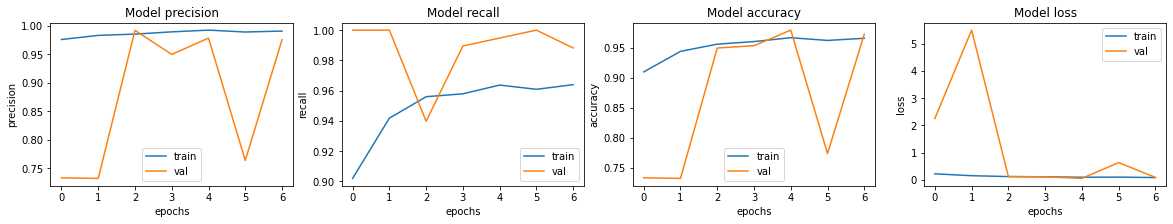

In [48]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_B.history[met])
    ax[i].plot(history_B.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#### 4. Dropout만

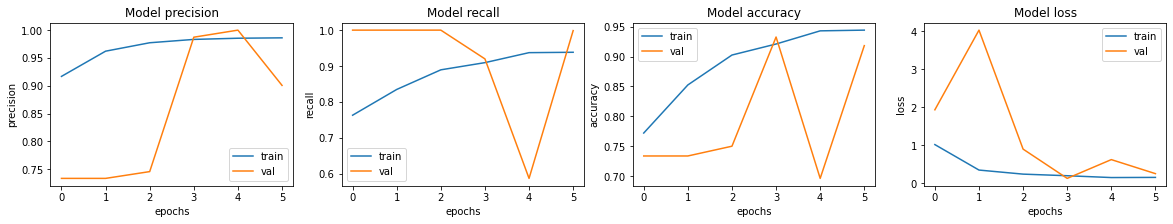

In [49]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_D.history[met])
    ax[i].plot(history_D.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#### 5. BatchNormalization & Dropout 둘 다 없음

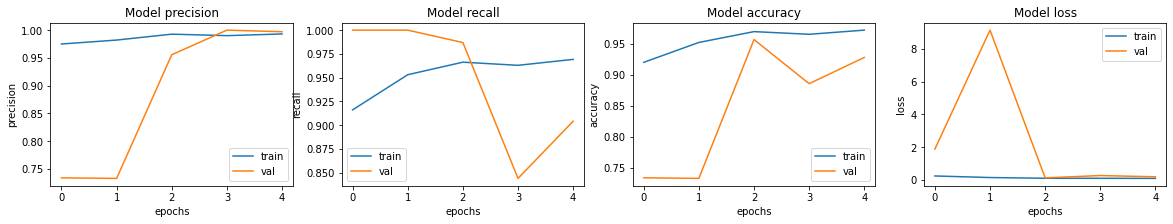

In [50]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_no.history[met])
    ax[i].plot(history_no.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#### 6. BatchNormalization & Dropout 둘 다 없음 + augmentation

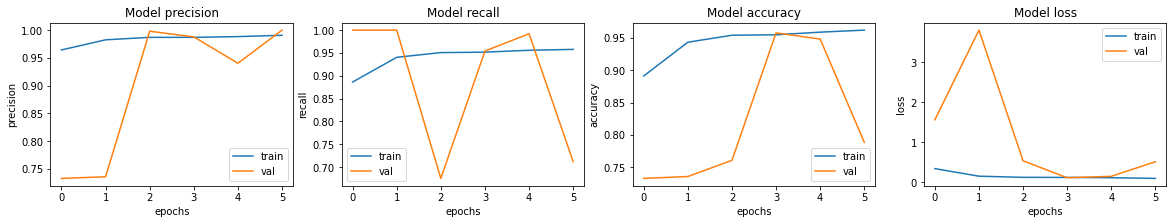

In [51]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_no_aug.history[met])
    ax[i].plot(history_no_aug.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#### 7. BatchNormalization만 + augmentation

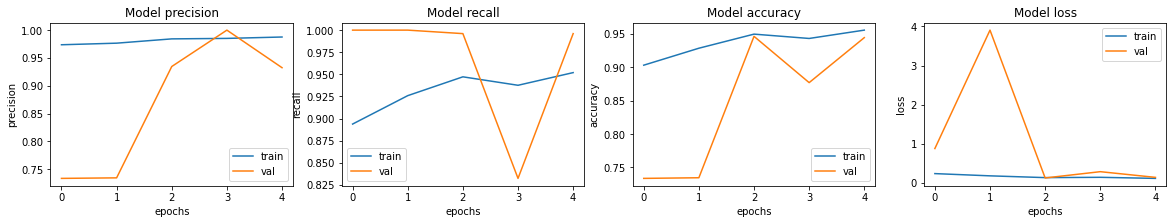

In [52]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_B_aug.history[met])
    ax[i].plot(history_B_aug.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#### 8. Dropout만 + augmentation

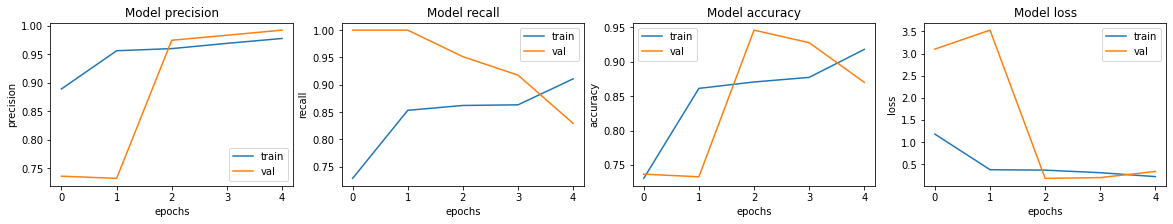

In [53]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_D_aug.history[met])
    ax[i].plot(history_D_aug.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

**테스트 데이터로 모델 평가**를 해보겠습니다.

모델 평가를 위해 loss, accuracy, precision, recall 값을 출력해보겠습니다.

#### 1. 기존 모델

In [54]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 76ms/step - loss: 1.2544 - accuracy: 0.7147 - precision: 0.6873 - recall: 0.9974
Loss: 1.2543771266937256,
Accuracy: 0.7147436141967773,
Precision: 0.6872791647911072,
Recall: 0.9974358677864075


#### 2. 기존 모델 + augmentation

In [55]:
loss, accuracy, precision, recall = model_aug.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 80ms/step - loss: 0.6022 - accuracy: 0.7917 - precision: 0.7539 - recall: 0.9897
Loss: 0.6021658778190613,
Accuracy: 0.7916666865348816,
Precision: 0.75390625,
Recall: 0.9897435903549194


#### 3. BatchNormalization만

In [56]:
loss, accuracy, precision, recall = model_B.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 73ms/step - loss: 1.2258 - accuracy: 0.7516 - precision: 0.7196 - recall: 0.9872
Loss: 1.2257969379425049,
Accuracy: 0.7516025900840759,
Precision: 0.7196261882781982,
Recall: 0.9871794581413269


#### 4. Dropout만

In [57]:
loss, accuracy, precision, recall = model_D.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 75ms/step - loss: 2.1149 - accuracy: 0.6699 - precision: 0.6544 - recall: 1.0000
Loss: 2.1148810386657715,
Accuracy: 0.6698718070983887,
Precision: 0.6543624401092529,
Recall: 1.0


#### 5. BatchNormalization & Dropout 둘 다 없음

In [58]:
loss, accuracy, precision, recall = model_no.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 77ms/step - loss: 0.5418 - accuracy: 0.8670 - precision: 0.8561 - recall: 0.9462
Loss: 0.5418258309364319,
Accuracy: 0.8669871687889099,
Precision: 0.8561484813690186,
Recall: 0.9461538195610046


#### 6. BatchNormalization & Dropout 둘 다 없음 + augmentation

In [59]:
loss, accuracy, precision, recall = model_no_aug.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 74ms/step - loss: 0.4811 - accuracy: 0.8093 - precision: 0.8883 - recall: 0.7949
Loss: 0.4811007082462311,
Accuracy: 0.8092948794364929,
Precision: 0.8882521390914917,
Recall: 0.7948718070983887


#### 7. BatchNormalization만 + augmentation

In [60]:
loss, accuracy, precision, recall = model_B_aug.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 75ms/step - loss: 1.1476 - accuracy: 0.6843 - precision: 0.6644 - recall: 1.0000
Loss: 1.147558569908142,
Accuracy: 0.6842948794364929,
Precision: 0.6643952131271362,
Recall: 1.0


#### 8. Dropout만 + augmentation

In [61]:
loss, accuracy, precision, recall = model_D_aug.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 75ms/step - loss: 0.4687 - accuracy: 0.8349 - precision: 0.8596 - recall: 0.8795
Loss: 0.4687109589576721,
Accuracy: 0.8349359035491943,
Precision: 0.859649121761322,
Recall: 0.879487156867981


***

# 회고

## 1.  다양한 실험
여러 방법을 시도 했는데 나눈 기준은 크게 
*  데이터 준비 :
    * augmentation을 한 경우 vs 안 한 경우
* 모델 구성(Dense Block) :
    * batchnormalization 사용 한 경우 vs 안 한 경우
    * dropout 사용 한 경우 vs 안 한 경우<br>
    
여기에 추가로 Convolution block에서 Convolution을 한번 진행했냐 두번 진행했냐로 나눠봤다.

## 2. 결과

#### 2-1. Convolution block에서 Convolution을 두번 진행한 경우

|모델|정확도|
|:--:|:--:|
|기존모델 (augmentation 안 함)|0.798|
|기존 모델 + augmentation|0.790|
|BatchNormalization만|0.691|
|BatchNormalization만 + augmentation|0.726|
|Dropout만|0.853|
|Dropout만 + augmentation|0.643|
|BatchNormalization & Dropout 둘 다 없음|0.678|
|BatchNormalization & Dropout 둘 다 없음 + augmentation|0.748|



* Dropout만 사용하고 augmentation을 안 한 것이 85.3%로 정확도가 가장 높았다.

#### 2-2. Convolution block에서 Convolution을 한번 진행한 경우

|모델|정확도|
|:--:|:--:|
|기존모델 (augmentation 안 함)|0.715|
|기존 모델 + augmentation|0.792|
|BatchNormalization만|0.752|
|BatchNormalization만 + augmentation|0.684|
|Dropout만|0.669|
|Dropout만 + augmentation|0.835|
|BatchNormalization & Dropout 둘 다 없음|0.866|
|BatchNormalization & Dropout 둘 다 없음 + augmentation|0.809|



* BatchNormalization & Dropout 둘 다 사용 안 하고 augmentation 안 한 것이 86.6%로 정확도가 가장 높았다.

## 3. 느낀점

* 대부분 epcoh 5~7만에 학습이 끝났다. 
* 모델을 더 바꿔보면 성능이 더 좋아지긴 할거 같다.
* 폐렴도 유방암분류처럼 폐렴을 폐렴이 아니라고 판단하면 안되기 때문에 recall이 중요할 거 같다. recall은 대부분 1에 가까웠는데 (BatchNormalization만 + augmentation) -> 이 경우와 Dropout만 썼을 때 1이 나왔다. 대신 둘다 정확도는 70퍼 미만이여서 좋은 건 아닌듯하다..